In [1]:
# 1. Import thư viện cần thiết
# from google.colab import drive
# drive.mount('/content/drive')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM

KeyboardInterrupt: 

In [ ]:
# 2. Đọc file csv và gắng index với giá Close
# df = pd.read_csv('/content/drive/MyDrive/StockData/AAPL_stock_data.csv')
df = pd.read_csv('../Datasets/AMD Historical Data.csv')
df1=df.reset_index()['Price']

In [ ]:
# 3. Scaler data
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [ ]:
# 4. Chia train test
train_size = int(0.7 * len(df1))
test_size = int(0.2 * len(df1))
val_size = len(df1) - train_size - test_size

train_data = df1[:train_size]
test_data = df1[train_size:train_size+test_size]
val_data = df1[train_size+test_size:]

In [ ]:
# 5. Hàm Create Dataset
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step-1):
		a = dataset[i:(i+time_step), 0]   ###i=0, X=0,1,2,3-----99   Y=100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return numpy.array(dataX), numpy.array(dataY)

In [ ]:
#6. Reshape into X=t,t+1,t+2..t+99 and Y=t+100

time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_val, yval = create_dataset(val_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [ ]:
# 7. Reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
X_val = X_val.reshape(X_val.shape[0],X_val.shape[1] , 1)

In [ ]:
# 8. Define LSTM Model

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
# 9. Fit mô hình với dữ liệu train
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
17/17 [==============================] - 12s 280ms/step - loss: 0.0188 - val_loss: 0.0391
Epoch 2/100
17/17 [==============================] - 2s 139ms/step - loss: 0.0021 - val_loss: 0.0055
Epoch 3/100
17/17 [==============================] - 2s 134ms/step - loss: 9.3050e-04 - val_loss: 0.0055
Epoch 4/100
17/17 [==============================] - 2s 132ms/step - loss: 7.1948e-04 - val_loss: 0.0058
Epoch 5/100
17/17 [==============================] - 2s 138ms/step - loss: 7.2599e-04 - val_loss: 0.0057
Epoch 6/100
17/17 [==============================] - 2s 141ms/step - loss: 9.4045e-04 - val_loss: 0.0075
Epoch 7/100
17/17 [==============================] - 2s 145ms/step - loss: 7.3479e-04 - val_loss: 0.0055
Epoch 8/100
17/17 [==============================] - 2s 144ms/step - loss: 6.4549e-04 - val_loss: 0.0054
Epoch 9/100
17/17 [==============================] - 3s 150ms/step - loss: 6.3290e-04 - val_loss: 0.0055
Epoch 10/100
17/17 [==============================] - 3s 150ms

In [ ]:
# 10. Dự báo dữ liệu test, val
train_predict=model.predict(X_train)
y_pred=model.predict(X_test)
y_pred_val=model.predict(X_val)

2/2 [==============================] - 0s 19ms/step


In [ ]:
# 11. Chuẩn hóa dữ liệu y_pred, y_pred_val
train_predict=scaler.inverse_transform(train_predict)
y_pred=scaler.inverse_transform(y_pred)
y_pred_val=scaler.inverse_transform(y_pred_val)

In [ ]:
# 12. Đánh giá độ chính xác thuật toán bằng RMSE
valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))

In [ ]:
# 13. Dự báo 30 ngày tiếp theo
x_input=val_data[-time_step:].reshape(1,-1)
x_input.shape

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
while(i<30):
    
    if(len(temp_input)>time_step):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


[0.6673059]
101
1 day input [0.34650217 0.35719911 0.37872424 0.3840399  0.39066807 0.40208689
 0.4033994  0.4072713  0.400315   0.38180864 0.39729623 0.43969025
 0.4276808  0.42905893 0.43069957 0.43227458 0.41291508 0.43063394
 0.49291246 0.51699698 0.50242814 0.48661242 0.50124688 0.49324058
 0.48352802 0.47217483 0.48300302 0.50150938 0.49645623 0.46298727
 0.45261845 0.44126526 0.44021525 0.46082163 0.44992781 0.45439034
 0.45314346 0.45124032 0.46534978 0.47243733 0.47007481 0.47630923
 0.49770311 0.48890931 0.47998425 0.47565297 0.5113532  0.52598766
 0.57140045 0.579538   0.57277858 0.56700354 0.57783174 0.5955506
 0.58025988 0.57146607 0.55801286 0.56805355 0.5798005  0.58065363
 0.57113794 0.56660979 0.54488778 0.54429715 0.5640504  0.55453472
 0.5433784  0.54180339 0.53957212 0.52723455 0.52664392 0.52769392
 0.52880956 0.51778449 0.5121407  0.48739992 0.50144376 0.51128757
 0.52395327 0.52605329 0.52749705 0.47309358 0.50584066 0.52703767
 0.56116288 0.56129413 0.57415671 0

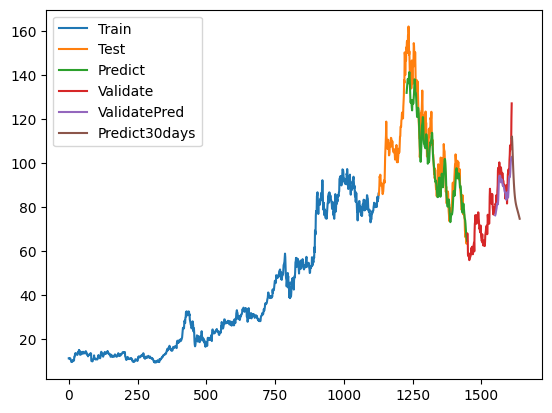

In [ ]:
# 14.Vẽ hình
train_data_index = pd.RangeIndex(start=0, stop=train_size, step=1)
plt.plot(scaler.inverse_transform(train_data))
test_data_index = pd.RangeIndex(start=train_size, stop=train_size+test_size, step=1)
plt.plot(test_data_index,scaler.inverse_transform(test_data))
test_data_index = pd.RangeIndex(start=train_size+time_step+1, stop=train_size+test_size, step=1)
plt.plot(test_data_index,(y_pred))
val_data_index = pd.RangeIndex(start=train_size+test_size, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,scaler.inverse_transform(val_data))
val_data_index = pd.RangeIndex(start=train_size+test_size+time_step+1, stop=train_size+test_size+val_size, step=1)
plt.plot(val_data_index,y_pred_val)
prediect_data_index = pd.RangeIndex(start=len(df1)-1, stop=len(df1)+29, step=1)
plt.plot(prediect_data_index,scaler.inverse_transform(lst_output))
plt.legend(['Train','Test','Predict','Validate','ValidatePred','Predict30days'])
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Regression metrics
test_rmse = np.sqrt(np.mean((y_pred - ytest)**2))
test_mse = mean_squared_error(ytest, y_pred)
test_mae = mean_absolute_error(ytest, y_pred)
test_mape = mape(ytest, y_pred)

valid_rmse = np.sqrt(np.mean((y_pred_val - yval)**2))
valid_mse = mean_squared_error(yval, y_pred_val)
valid_mae = mean_absolute_error(yval, y_pred_val)
valid_mape = mape(yval, y_pred_val)

print('Testing RMSE:', test_rmse)
# print('Testing MSE:', test_mse)
print('Testing MAE:', test_mae)
print("Testing MAPE:", test_mape)

print('Validation RMSE:', valid_rmse)
# print('Validation MSE:', valid_mse)
print('Validation MAE:', valid_mae)
print("Validation MAPE:", valid_mape)


Testing RMSE: 101.92944240608726
Testing MSE: 10383.791545559547
Testing MAE: 100.11250609174121
Validation RMSE: 88.31245369459967
Validation MSE: 7798.486099097844
Validation MAE: 88.08449380005699


In [ ]:
print(scaler.inverse_transform(lst_output)[:10, 0])

[111.21407102 112.00390824 109.65241638 106.16161782 102.51637039
  99.06795102  95.93164461  93.14898567  90.72958354  88.66104963]


In [ ]:
print(df['Price'].tail(10))

1601     97.40
1602    101.48
1603    103.75
1604    107.93
1605    105.82
1606    108.00
1607    108.12
1608    108.27
1609    120.35
1610    127.03
Name: Price, dtype: float64


In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

# pred_ind = list(range(len(df1), len(df1)+30))
# x_train_ind = list(range(0, train_size))
# x_test_ind = list(range(train_size, train_size+test_size))
# x_validation_ind = list(range(train_size+test_size, len(df1)))
# pred_ind = list(range(len(df1), len(df1)+30))

fig = go.Figure()
fig.add_trace(go.Scatter(x=train_data_index, y=scaler.inverse_transform(train_data)[:, 0], mode='lines+markers', marker=dict(size=4),  name='Train', marker_color='#1F77B4'))
fig.add_trace(go.Scatter(x=test_data_index,y=scaler.inverse_transform(test_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Test', marker_color='#FF7F0E'))
fig.add_trace(go.Scatter(x=test_data_index,y=y_pred[:, 0], mode='lines+markers', marker=dict(size=4), name='Prediction', marker_color='#2CA02C'))
fig.add_trace(go.Scatter(x=val_data_index, y=scaler.inverse_transform(val_data)[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#D62728'))
fig.add_trace(go.Scatter(x=val_data_index, y=y_pred_val[:, 0], mode='lines+markers', marker=dict(size=4), name='Validate', marker_color='#9569BE'))
fig.add_trace(go.Scatter(x=prediect_data_index, y=scaler.inverse_transform(lst_output)[:, 0], mode='lines+markers', marker=dict(size=4), name='Next30Day', marker_color='#000000'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=.5, xanchor="center"),
                  plot_bgcolor='#FFFFFF',  
                  xaxis=dict(gridcolor = 'lightgrey'),
                  yaxis=dict(gridcolor = 'lightgrey'),    
                  title_text = f'AMD LSTM data (6:2:2)', title_x = 0.5,
                  xaxis_title="Timestep",
                  yaxis_title="Stock price",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()